In [1]:
import datetime
import re

import nltk
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR
from textblob import TextBlob

In [2]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# Stats

# Misc
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

In [3]:
train = pd.read_csv('Dataset/train_file.csv')
test = pd.read_csv('Dataset/test_file.csv')
submission = pd.read_csv('Dataset/sample_submission.csv')
test_id = test['IDLink']

In [4]:
train.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,Facebook,GooglePlus,LinkedIn,SentimentTitle,SentimentHeadline
0,Tr3CMgRv1N,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,-1,-1,-1,0.000000,-0.053300
1,Wc81vGp8qZ,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,-1,-1,-1,0.208333,-0.156386
2,zNGH03CrZH,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-1,-1,-1,-0.425210,0.139754
3,3sM1H0W8ts,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,-1,-1,-1,0.000000,0.026064
4,wUbnxgvqaZ,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,-1,-1,-1,0.000000,0.141084


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55932 entries, 0 to 55931
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   IDLink             55932 non-null  object 
 1   Title              55932 non-null  object 
 2   Headline           55932 non-null  object 
 3   Source             55757 non-null  object 
 4   Topic              55932 non-null  object 
 5   PublishDate        55932 non-null  object 
 6   Facebook           55932 non-null  int64  
 7   GooglePlus         55932 non-null  int64  
 8   LinkedIn           55932 non-null  int64  
 9   SentimentTitle     55932 non-null  float64
 10  SentimentHeadline  55932 non-null  float64
dtypes: float64(2), int64(3), object(6)
memory usage: 4.7+ MB


In [6]:
train.describe()

,Facebook,GooglePlus,LinkedIn,SentimentTitle,SentimentHeadline
count,55932.000000,55932.000000,55932.000000,55932.000000,55932.000000
mean,132.050329,4.551616,14.300132,-0.006318,-0.029577
std,722.931314,21.137177,76.651420,0.137569,0.143038
min,-1.000000,-1.000000,-1.000000,-0.838525,-0.755355
25%,0.000000,0.000000,0.000000,-0.079057,-0.116927
50%,6.000000,0.000000,0.000000,0.000000,-0.027277
75%,37.000000,2.000000,4.000000,0.063969,0.057354
max,49211.000000,1267.000000,3716.000000,0.962354,0.964646


In [7]:
train.isnull().sum()

IDLink                 0
Title                  0
Headline               0
Source               175
Topic                  0
PublishDate            0
Facebook               0
GooglePlus             0
LinkedIn               0
SentimentTitle         0
SentimentHeadline      0
dtype: int64

In [8]:
test.isnull().sum()

IDLink           0
Title            0
Headline         0
Source         101
Topic            0
PublishDate      0
Facebook         0
GooglePlus       0
LinkedIn         0
dtype: int64

In [9]:
train['Source'].value_counts()[:6]

Bloomberg           992
Reuters             763
ABC News            645
New York Times      573
The Guardian        551
Business Insider    550
Name: Source, dtype: int64

In [10]:
train['Source'] = train['Source'].fillna('Bloomberg')
test['Source'] = test['Source'].fillna('Bloomberg')

In [11]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop = set(stopwords.words('english'))

def clean(text):
  text_token = word_tokenize(text)
  filtered_text = ' '.join([w.lower() for w in text_token if w.lower() not in stop and len(w) > 2])
  filtered_text = filtered_text.replace(r"[^a-zA-Z]+", '')
  text_only = re.sub(r'\b\d+\b', '', filtered_text)
  clean_text = text_only.replace(',', '').replace('.', '').replace(':', '')
  return clean_text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
train['Text_Title'] = train['Title'] + ' ' + train['Source'] + ' ' + train['Topic']
test['Text_Title'] = test['Title'] + ' ' + test['Source'] + ' ' + test['Topic']

train['Text_Headline'] = train['Headline'] + ' ' + train['Source'] + ' ' + train['Topic']
test['Text_Headline'] = test['Headline'] + ' ' + test['Source'] + ' ' + test['Topic']

In [13]:
train['Text_Title'][6]

'Monday, 29 Feb 2016 Bloomberg palestine'

In [14]:
train['Text_Title'] = [clean(x) for x in train['Text_Title']]
test['Text_Title'] = [clean(x) for x in test['Text_Title']]

train['Text_Headline'] = [clean(x) for x in train['Text_Headline']]
test['Text_Headline'] = [clean(x) for x in test['Text_Headline']]

In [15]:
'''
import tensorflow as tf
tf.test.gpu_device_name()
'''

'\nimport tensorflow as tf\ntf.test.gpu_device_name()\n'

In [16]:
'/device:GPU:0'

'/device:GPU:0'

In [17]:
text = ""
for ind, row in train.iterrows():
    text += row["Text_Title"] + " "
text = text.strip()


In [18]:
text = ""
for ind, row in train.iterrows():
    text += row["Text_Headline"] + " "
text = text.strip()

In [19]:
vectorizer = TfidfVectorizer(use_idf=True)

train_v_Title = vectorizer.fit_transform(train['Text_Title'])
test_v_Title = vectorizer.transform(test['Text_Title'])

vectorizer_ = TfidfVectorizer()

train_v_Headline = vectorizer_.fit_transform(train['Text_Headline'])
test_v_Headline = vectorizer_.transform(test['Text_Headline'])

In [20]:
train['polarity_t'] = train['Title'].apply(lambda x: TextBlob(x).sentiment.polarity)
test['polarity_t'] = test['Title'].apply(lambda x: TextBlob(x).sentiment.polarity)

train['subjectivity_t'] = train['Title'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
test['subjectivity_t'] = test['Title'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [21]:
train['polarity_h'] = train['Headline'].apply(lambda x: TextBlob(x).sentiment.polarity)
test['polarity_h'] = test['Headline'].apply(lambda x: TextBlob(x).sentiment.polarity)

train['subjectivity_h'] = train['Headline'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
test['subjectivity_h'] = test['Headline'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [22]:
encoder = 

train['Topic'] = encoder.fit_transform(train['Topic'])
test['Topic'] = encoder.transform(test['Topic'])

total = train['Source'].to_list() + test['Source'].to_list()
total = encoder.fit_transform(total)
train['Source'] = encoder.transform(train['Source'])
test['Source'] = encoder.transform(test['Source'])

In [23]:
train_weekday = []
test_weekday = []

for i in train['PublishDate']:
    train_weekday.append(datetime.datetime.strptime(i, "%Y-%m-%d %H:%M:%S").strftime("%A"))
    
for i in test['PublishDate']:
    test_weekday.append(datetime.datetime.strptime(i, "%Y-%m-%d %H:%M:%S").strftime("%A"))

train['weekday'] = train_weekday
test['weekday'] = test_weekday


# convert weekday to 0-6

train['weekday'] = train['weekday'].map({'Monday': 0,
                                        'Tuesday': 1,
                                        'Wednesday': 2,
                                        'Thursday': 3,
                                        'Friday': 4,
                                        'Saturday': 5,
                                        'Sunday': 6})
test['weekday'] = test['weekday'].map({'Monday': 0,
                                        'Tuesday': 1,
                                        'Wednesday': 2,
                                        'Thursday': 3,
                                        'Friday': 4,
                                        'Saturday': 5,
                                        'Sunday': 6})

In [24]:
train["hour"] = train["PublishDate"].apply(lambda x: x.split()[1].split(':')[0])
test["hour"] = test["PublishDate"].apply(lambda x: x.split()[1].split(':')[0])

In [25]:
# Number of words in the Title 
train["num_words_t"] = train["Text_Title"].apply(lambda x: len(str(x).split()))
test["num_words_t"] = test["Text_Title"].apply(lambda x: len(str(x).split()))

# Number of unique words in the Title 
train["num_unique_words_t"] = train["Text_Title"].apply(lambda x: len(set(str(x).split())))
test["num_unique_words_t"] = test["Text_Title"].apply(lambda x: len(set(str(x).split())))

# Number of characters in the Title 
train["num_chars_t"] = train["Text_Title"].apply(lambda x: len(str(x)))
test["num_chars_t"] = test["Text_Title"].apply(lambda x: len(str(x)))

# Average length of the words in the Title 
train["mean_word_len_t"] = train["Text_Title"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test["mean_word_len_t"] = test["Text_Title"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [26]:
# Number of words in the Headline 
train["num_words_h"] = train["Text_Headline"].apply(lambda x: len(str(x).split()))
test["num_words_h"] = test["Text_Headline"].apply(lambda x: len(str(x).split()))

# Number of unique words in the Headline 
train["num_unique_words_h"] = train["Text_Headline"].apply(lambda x: len(set(str(x).split())))
test["num_unique_words_h"] = test["Text_Headline"].apply(lambda x: len(set(str(x).split())))

# Number of characters in the Headline 
train["num_chars_h"] = train["Text_Headline"].apply(lambda x: len(str(x)))
test["num_chars_h"] = test["Text_Headline"].apply(lambda x: len(str(x)))

# Average length of the words in the Headline 
train["mean_word_len_h"] = train["Text_Headline"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test["mean_word_len_h"] = test["Text_Headline"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [27]:
scaler = StandardScaler()

cols = ['Source', 'Topic', 'Facebook', 'GooglePlus', 'LinkedIn', 'num_words_t', 'num_unique_words_t', 'num_chars_t', 'mean_word_len_t',
        'num_words_h', 'num_unique_words_h', 'num_chars_h', 'mean_word_len_h', 'hour', 'weekday']

for col in cols:
  train[col] = scaler.fit_transform(train[col].values.reshape(-1, 1))
  test[col] = scaler.transform(test[col].values.reshape(-1, 1))

In [28]:
cols_t = ['Source', 'Topic', 'Facebook', 'GooglePlus', 'LinkedIn', 'num_words_t', 'num_unique_words_t', 'num_chars_t', 'mean_word_len_t', 'polarity_t', 'subjectivity_t', 'hour', 'weekday']
train_X1 = train[cols_t]
test_X1 = test[cols_t]

cols_h = ['Source', 'Topic', 'Facebook', 'GooglePlus', 'LinkedIn', 'num_words_h', 'num_unique_words_h', 'num_chars_h', 'mean_word_len_h', 'polarity_h', 'subjectivity_h', 'hour', 'weekday']
train_X2 = train[cols_h]
test_X2 = test[cols_h]

In [29]:
train_X_Title = hstack([train_v_Title, csr_matrix(train_X1.values)])
test_X_Title = hstack([test_v_Title, csr_matrix(test_X1.values)])
y1 = train['SentimentTitle']

train_X_Headline = hstack([train_v_Headline, csr_matrix(train_X2.values)])
test_X_Headline = hstack([test_v_Headline, csr_matrix(test_X2.values)])
y2 = train['SentimentHeadline']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(train_X_Title, y1, test_size=0.20, random_state=42)

clf1 = LinearSVR(C=0.2)
clf1.fit(X_train, y_train)

y_pred1 = clf1.predict(X_test)
mae1 = mean_absolute_error(y_pred1, y_test)
print('MAE:', 1 - mae1)

MAE: 0.9433379199351876


In [31]:
X_train, X_test, y_train, y_test = train_test_split(train_X_Headline, y2, test_size=0.20, random_state=42)

clf2 = LinearSVR(C=0.1)
clf2.fit(X_train, y_train)

y_pred2 = clf2.predict(X_test)
mae2 = mean_absolute_error(y_pred2, y_test)
print('MAE:', 1 - mae2)

MAE: 0.9291381949857027


In [32]:
'''
train = pd.read_csv('/content/train_file.csv')
test = pd.read_csv('/content/test_file.csv')
submission = pd.read_csv('/content/sample_submission.csv')
test_id = test['IDLink']
'''

"\ntrain = pd.read_csv('/content/train_file.csv')\ntest = pd.read_csv('/content/test_file.csv')\nsubmission = pd.read_csv('/content/sample_submission.csv')\ntest_id = test['IDLink']\n"

import sys

!{sys.executable} -m pip install -U pandas-profiling[notebook]

!jupyter nbextension enable --py widgetsnbextension



from tqdm import tqdm
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!jupyter labextension install @jupyter-widgets/jupyterlab-manager




In [33]:
from sklearn.ensemble import RandomForestRegressor

In [34]:
clf = RandomForestRegressor(n_estimators=500, n_jobs=-1)
clf.fit(X_train, y_train)

clfRidge = Ridge(alpha=1.0)
clfRidge.fit(X_train, y_train)

clfLasso = Lasso(alpha=0.1)
clfRidge.fit(X_train, y_train)

clfRidgeCV = RidgeCV(alphas = [1e-3, 1e-2, 1e-1, 1])
clfRidgeCV.fit(X_train, y_train)


clfElasticNet = ElasticNet(random_state=42)
clfElasticNet.fit(X_train, y_train)

clfDT = DecisionTreeRegressor(random_state=42)
clfDT.fit(X_train, y_train)

clfKNN = KNeighborsRegressor(n_neighbors=2)
clfKNN.fit(X_train, y_train)

MemoryError: Unable to allocate 11.2 GiB for an array with shape (38797, 38797) and data type float64

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
y_pred

In [ ]:
y_test

In [ ]:
y_train.head()

In [35]:
clfElasticNet = ElasticNet(random_state=42)
clfElasticNet.fit(X_train, y_train)

clfDT = DecisionTreeRegressor(random_state=42)
clfDT.fit(X_train, y_train)

clfKNN = KNeighborsRegressor(n_neighbors=2)
clfKNN.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=2)

In [36]:
'''
cat_columns = []

for col in train_df.select_dtypes('object').columns:
    print(col)
    cat_columns.append(col)
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
'''


"\ncat_columns = []\n\nfor col in train_df.select_dtypes('object').columns:\n    print(col)\n    cat_columns.append(col)\n    le = LabelEncoder()\n    train_df[col] = le.fit_transform(train_df[col])\n"

cat_features_index = [i for i, col in enumerate(train_df.columns) if col in cat_columns]


NUM_OF_BOOST_ROUND = 10000
EARLY_STOPPING = 300

In [37]:
clfLasso.fit(X_train, y_train)


Lasso(alpha=0.1)

In [38]:
y_pred = clfLasso.predict(X_test)

In [39]:
y_pred

array([-0.02996178, -0.02996178, -0.02996178, ..., -0.02996178,
       -0.02996178, -0.02996178])

In [40]:
from sklearn.ensemble import VotingRegressor, BaggingRegressor, StackingRegressor, GradientBoostingRegressor



In [42]:
ensGB = GradientBoostingRegressor(random_state=0)
ensGB.fit(X_train, y_train).score(X_test, y_test)

0.20598868017110838

In [43]:
estimators = [
('lr', clfRidge),
('la', clfLasso),
('en', clfElasticNet),
('dt', clfDT),
('knn', clfKNN),
('svr', clf1)
]

In [44]:
ensST = StackingRegressor(
    estimators=estimators,
    final_estimator=clf )
ensST.fit(X_train, y_train).score(X_test, y_test)

0.5236720228630106

In [45]:
ensVR = VotingRegressor(estimators=estimators)
ensVR.fit(X_train, y_train).score(X_test, y_test)

0.37867756626623883

In [46]:
ensBG = BaggingRegressor(base_estimator=clf,n_estimators=10, random_state=0).fit(X_train, y_train).score(X_test, y_test)

KeyboardInterrupt: 

In [53]:
from sklearn.metrics import explained_variance_score, max_error\
                            ,mean_absolute_error\
                            ,mean_squared_error\
                            ,mean_squared_log_error\
                            ,median_absolute_error\
                            ,r2_score\
                            ,mean_poisson_deviance\
                            ,mean_gamma_deviance

def regscore(algo):
    y_pred = algo.predict(X_test)
    
    print("Explained Variance Score: ",explained_variance_score(y_test, y_pred))
    print("Max Error: ",max_error(y_test, y_pred))
    print("Mean Absolute Error: ",mean_absolute_error(y_test, y_pred))
    print("Mean Squared Error: ",mean_squared_error(y_test, y_pred))
    print("Mean Squared Log Error: ",mean_squared_log_error(y_test, y_pred))
    print("Median Absolute Error: ",median_absolute_error(y_test, y_pred))
    # print("Mean Absolute % Error: ",mean_absolute_percentage_error(y_test, y_pred))
    print("R^2 Score: ",r2_score(y_test, y_pred))
    print("Mean Poisson Deviance: ",mean_poisson_deviance(y_test, y_pred))
    print("Mean Gamma Deviance: ",mean_gamma_deviance(y_test, y_pred))


In [61]:
y_pred = clf.predict(X_test)

In [67]:
print("RANDOM FOREST REGRESSION")
print("Explained Variance Score: ",explained_variance_score(y_test, y_pred))
print("Explained Variance Score: ",explained_variance_score(y_test, y_pred))
print("Max Error: ",max_error(y_test, y_pred))
print("Mean Absolute Error: ",mean_absolute_error(y_test, y_pred))
print("Mean Squared Error: ",mean_squared_error(y_test, y_pred))
# print("Mean Squared Log Error: ",mean_squared_log_error(y_test, y_pred))
print("Median Absolute Error: ",median_absolute_error(y_test, y_pred))
    # print("Mean Absolute % Error: ",mean_absolute_percentage_error(y_test, y_pred))
print("R^2 Score: ",r2_score(y_test, y_pred))
# print("Mean Poisson Deviance: ",mean_poisson_deviance(y_test, y_pred))
# print("Mean Gamma Deviance: ",mean_gamma_deviance(y_test, y_pred))

RANDOM FOREST REGRESSION
Explained Variance Score:  0.3754662992366208
Explained Variance Score:  0.3754662992366208
Max Error:  0.6453005986747211
Mean Absolute Error:  0.08377584950377034
Mean Squared Error:  0.012658294655291485
Median Absolute Error:  0.06372603753444438
R^2 Score:  0.3753906144232232


In [ ]:
y_pred = clf.predict(X_test)

In [71]:
y_pred = clfElasticNet.predict(X_test)
print("ELASTIC NETS")
print("Explained Variance Score: ",explained_variance_score(y_test, y_pred))
print("Explained Variance Score: ",explained_variance_score(y_test, y_pred))
print("Max Error: ",max_error(y_test, y_pred))
print("Mean Absolute Error: ",mean_absolute_error(y_test, y_pred))
print("Mean Squared Error: ",mean_squared_error(y_test, y_pred))
print("Median Absolute Error: ",median_absolute_error(y_test, y_pred))
print("R^2 Score: ",r2_score(y_test, y_pred))
# print("Mean Poisson Deviance: ",mean_poisson_deviance(y_test, y_pred))
# print("Mean Gamma Deviance: ",mean_gamma_deviance(y_test, y_pred))
# print("Mean Squared Log Error: ",mean_squared_log_error(y_test, y_pred))
# print("Mean Absolute % Error: ",mean_absolute_percentage_error(y_test, y_pred))



ELASTIC NETS
Explained Variance Score:  0.0
Explained Variance Score:  0.0
Max Error:  0.7695915826424073
Mean Absolute Error:  0.10934995597314702
Mean Squared Error:  0.020269633288537012
Median Absolute Error:  0.08672417053070185
R^2 Score:  -0.0001823736128021558


In [72]:
y_pred = clfRidge.predict(X_test)
print("RIDGE REGRESSION")
print("Explained Variance Score: ",explained_variance_score(y_test, y_pred))
print("Explained Variance Score: ",explained_variance_score(y_test, y_pred))
print("Max Error: ",max_error(y_test, y_pred))
print("Mean Absolute Error: ",mean_absolute_error(y_test, y_pred))
print("Mean Squared Error: ",mean_squared_error(y_test, y_pred))
print("Median Absolute Error: ",median_absolute_error(y_test, y_pred))
print("R^2 Score: ",r2_score(y_test, y_pred))
# print("Mean Poisson Deviance: ",mean_poisson_deviance(y_test, y_pred))
# print("Mean Gamma Deviance: ",mean_gamma_deviance(y_test, y_pred))
# print("Mean Squared Log Error: ",mean_squared_log_error(y_test, y_pred))
# print("Mean Absolute % Error: ",mean_absolute_percentage_error(y_test, y_pred))

RIDGE REGRESSION
Explained Variance Score:  0.5332691852163784
Explained Variance Score:  0.5332691852163784
Max Error:  0.720209323483589
Mean Absolute Error:  0.07195100496698752
Mean Squared Error:  0.009458765371788965
Median Absolute Error:  0.05443684704128328
R^2 Score:  0.533267806756395


In [73]:
y_pred = clfLasso.predict(X_test)
print("LASSO REGRESSION")
print("Explained Variance Score: ",explained_variance_score(y_test, y_pred))
print("Explained Variance Score: ",explained_variance_score(y_test, y_pred))
print("Max Error: ",max_error(y_test, y_pred))
print("Mean Absolute Error: ",mean_absolute_error(y_test, y_pred))
print("Mean Squared Error: ",mean_squared_error(y_test, y_pred))
print("Median Absolute Error: ",median_absolute_error(y_test, y_pred))
print("R^2 Score: ",r2_score(y_test, y_pred))
# print("Mean Poisson Deviance: ",mean_poisson_deviance(y_test, y_pred))
# print("Mean Gamma Deviance: ",mean_gamma_deviance(y_test, y_pred))
# print("Mean Squared Log Error: ",mean_squared_log_error(y_test, y_pred))
# print("Mean Absolute % Error: ",mean_absolute_percentage_error(y_test, y_pred))

LASSO REGRESSION
Explained Variance Score:  0.0
Explained Variance Score:  0.0
Max Error:  0.7695915826424073
Mean Absolute Error:  0.10934995597314702
Mean Squared Error:  0.020269633288537012
Median Absolute Error:  0.08672417053070185
R^2 Score:  -0.0001823736128021558


In [74]:
y_pred = clfDT.predict(X_test)
print("DECISION TREES REGRESSION")
print("Explained Variance Score: ",explained_variance_score(y_test, y_pred))
print("Explained Variance Score: ",explained_variance_score(y_test, y_pred))
print("Max Error: ",max_error(y_test, y_pred))
print("Mean Absolute Error: ",mean_absolute_error(y_test, y_pred))
print("Mean Squared Error: ",mean_squared_error(y_test, y_pred))
print("Median Absolute Error: ",median_absolute_error(y_test, y_pred))
print("R^2 Score: ",r2_score(y_test, y_pred))
# print("Mean Poisson Deviance: ",mean_poisson_deviance(y_test, y_pred))
# print("Mean Gamma Deviance: ",mean_gamma_deviance(y_test, y_pred))
# print("Mean Squared Log Error: ",mean_squared_log_error(y_test, y_pred))
# print("Mean Absolute % Error: ",mean_absolute_percentage_error(y_test, y_pred))

DECISION TREES REGRESSION
Explained Variance Score:  -0.10490278644360518
Explained Variance Score:  -0.10490278644360518
Max Error:  0.8780334486914763
Mean Absolute Error:  0.10978541114249249
Mean Squared Error:  0.022394382040141395
Median Absolute Error:  0.0841601971075437
R^2 Score:  -0.10502572324124992


In [75]:
y_pred = clfKNN.predict(X_test)
print("k-NEIGHBOURS REGRESSION")
print("Explained Variance Score: ",explained_variance_score(y_test, y_pred))
print("Explained Variance Score: ",explained_variance_score(y_test, y_pred))
print("Max Error: ",max_error(y_test, y_pred))
print("Mean Absolute Error: ",mean_absolute_error(y_test, y_pred))
print("Mean Squared Error: ",mean_squared_error(y_test, y_pred))
print("Median Absolute Error: ",median_absolute_error(y_test, y_pred))
print("R^2 Score: ",r2_score(y_test, y_pred))
# print("Mean Poisson Deviance: ",mean_poisson_deviance(y_test, y_pred))
# print("Mean Gamma Deviance: ",mean_gamma_deviance(y_test, y_pred))
# print("Mean Squared Log Error: ",mean_squared_log_error(y_test, y_pred))
# print("Mean Absolute % Error: ",mean_absolute_percentage_error(y_test, y_pred))

k-NEIGHBOURS REGRESSION
Explained Variance Score:  -0.2911120037621875
Explained Variance Score:  -0.2911120037621875
Max Error:  0.8237983217248042
Mean Absolute Error:  0.12386549611926422
Mean Squared Error:  0.026165784613515593
Median Absolute Error:  0.09918820642960491
R^2 Score:  -0.29112136315694825


In [77]:
y_pred = ensGB.predict(X_test)
print("GRADIENT BOOSITNG REGRESSION")
print("Explained Variance Score: ",explained_variance_score(y_test, y_pred))
print("Explained Variance Score: ",explained_variance_score(y_test, y_pred))
print("Max Error: ",max_error(y_test, y_pred))
print("Mean Absolute Error: ",mean_absolute_error(y_test, y_pred))
print("Mean Squared Error: ",mean_squared_error(y_test, y_pred))
print("Median Absolute Error: ",median_absolute_error(y_test, y_pred))
print("R^2 Score: ",r2_score(y_test, y_pred))
# print("Mean Poisson Deviance: ",mean_poisson_deviance(y_test, y_pred))
# print("Mean Gamma Deviance: ",mean_gamma_deviance(y_test, y_pred))
# print("Mean Squared Log Error: ",mean_squared_log_error(y_test, y_pred))
# print("Mean Absolute % Error: ",mean_absolute_percentage_error(y_test, y_pred))

GRADIENT BOOSITNG REGRESSION
Explained Variance Score:  0.20627282092625965
Explained Variance Score:  0.20627282092625965
Max Error:  0.6616571242142424
Mean Absolute Error:  0.09745015573083572
Mean Squared Error:  0.016091383636110207
Median Absolute Error:  0.0787629524547549
R^2 Score:  0.20598868017110838


In [78]:
y_pred = ensST.predict(X_test)
print("STACKING REGRESSION")
print("Explained Variance Score: ",explained_variance_score(y_test, y_pred))
print("Explained Variance Score: ",explained_variance_score(y_test, y_pred))
print("Max Error: ",max_error(y_test, y_pred))
print("Mean Absolute Error: ",mean_absolute_error(y_test, y_pred))
print("Mean Squared Error: ",mean_squared_error(y_test, y_pred))
print("Median Absolute Error: ",median_absolute_error(y_test, y_pred))
print("R^2 Score: ",r2_score(y_test, y_pred))
# print("Mean Poisson Deviance: ",mean_poisson_deviance(y_test, y_pred))
# print("Mean Gamma Deviance: ",mean_gamma_deviance(y_test, y_pred))
# print("Mean Squared Log Error: ",mean_squared_log_error(y_test, y_pred))
# print("Mean Absolute % Error: ",mean_absolute_percentage_error(y_test, y_pred))

STACKING REGRESSION
Explained Variance Score:  0.5237220647772931
Explained Variance Score:  0.5237220647772931
Max Error:  0.7580093829819871
Mean Absolute Error:  0.07213162051756744
Mean Squared Error:  0.009653232926673356
Median Absolute Error:  0.05326959359890879
R^2 Score:  0.5236720228630107


In [79]:
y_pred = ensVR.predict(X_test)
print("VOTING REGRESSION")
print("Explained Variance Score: ",explained_variance_score(y_test, y_pred))
print("Explained Variance Score: ",explained_variance_score(y_test, y_pred))
print("Max Error: ",max_error(y_test, y_pred))
print("Mean Absolute Error: ",mean_absolute_error(y_test, y_pred))
print("Mean Squared Error: ",mean_squared_error(y_test, y_pred))
print("Median Absolute Error: ",median_absolute_error(y_test, y_pred))
print("R^2 Score: ",r2_score(y_test, y_pred))
# print("Mean Poisson Deviance: ",mean_poisson_deviance(y_test, y_pred))
# print("Mean Gamma Deviance: ",mean_gamma_deviance(y_test, y_pred))
# print("Mean Squared Log Error: ",mean_squared_log_error(y_test, y_pred))
# print("Mean Absolute % Error: ",mean_absolute_percentage_error(y_test, y_pred))

VOTING REGRESSION
Explained Variance Score:  0.37867763534030185
Explained Variance Score:  0.37867763534030185
Max Error:  0.5788552566142677
Mean Absolute Error:  0.0850450862359069
Mean Squared Error:  0.012591681495279129
Median Absolute Error:  0.06667888105086547
R^2 Score:  0.37867756626623883


In [80]:
y_pred2 = clf2.predict(X_test)
print("LINEAR SVR")
print("Explained Variance Score: ",explained_variance_score(y_test, y_pred))
print("Explained Variance Score: ",explained_variance_score(y_test, y_pred))
print("Max Error: ",max_error(y_test, y_pred))
print("Mean Absolute Error: ",mean_absolute_error(y_test, y_pred))
print("Mean Squared Error: ",mean_squared_error(y_test, y_pred))
print("Median Absolute Error: ",median_absolute_error(y_test, y_pred))
print("R^2 Score: ",r2_score(y_test, y_pred))

LINEAR SVR
Explained Variance Score:  0.37867763534030185
Explained Variance Score:  0.37867763534030185
Max Error:  0.5788552566142677
Mean Absolute Error:  0.0850450862359069
Mean Squared Error:  0.012591681495279129
Median Absolute Error:  0.06667888105086547
R^2 Score:  0.37867756626623883


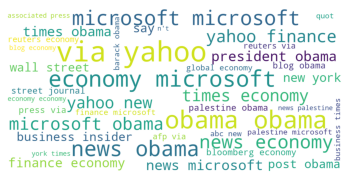

In [88]:
text = ""
for ind, row in train.iterrows():
    text += row["Text_Title"] + " "
text = text.strip()

wordcloud = WordCloud(background_color='white', width=1200, height=600, max_font_size=100, max_words=40).generate(text)
wordcloud.recolor(random_state=ind*312)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

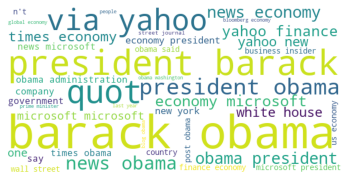

In [89]:
text = ""
for ind, row in train.iterrows():
    text += row["Text_Headline"] + " "
text = text.strip()

wordcloud = WordCloud(background_color='white', width=600, height=300, max_font_size=100, max_words=40).generate(text)
wordcloud.recolor(random_state=ind*312)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()